In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/train')

import torch
import numpy as np
from torch.autograd import Variable
import torch.optim as optim
import argparse
import random
import os
import models
import torchvision.utils as vutils
import utils
import dataLoader
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
import os, inspect
pwdpath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))

parser = argparse.ArgumentParser()
# The locationi of training set
parser.add_argument('--dataRoot', default=None, help='path to input images')
parser.add_argument('--experiment', default=None, help='the path to store samples and models')
# The basic training setting
parser.add_argument('--nepoch0', type=int, default=14, help='the number of epochs for training')
parser.add_argument('--nepoch1', type=int, default=10, help='the number of epochs for training')

parser.add_argument('--batchSize0', type=int, default=16, help='input batch size')
parser.add_argument('--batchSize1', type=int, default=16, help='input batch size')

parser.add_argument('--imHeight0', type=int, default=240, help='the height / width of the input image to network')
parser.add_argument('--imWidth0', type=int, default=320, help='the height / width of the input image to network')
parser.add_argument('--imHeight1', type=int, default=240, help='the height / width of the input image to network')
parser.add_argument('--imWidth1', type=int, default=320, help='the height / width of the input image to network')

parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--deviceIds', type=int, nargs='+', default=[0, 1, 2], help='the gpus used for training network')
# Fine tune the network
parser.add_argument('--isFineTune', action='store_true', help='fine-tune the network')
parser.add_argument('--epochIdFineTune', type=int, default = 0, help='the training of epoch of the loaded model')
# The training weight
parser.add_argument('--albedoWeight', type=float, default=1.5, help='the weight for the diffuse component')
parser.add_argument('--normalWeight', type=float, default=1.0, help='the weight for the diffuse component')
parser.add_argument('--roughWeight', type=float, default=0.5, help='the weight for the roughness component')
parser.add_argument('--depthWeight', type=float, default=0.5, help='the weight for depth component')

# Cascae Level
parser.add_argument('--cascadeLevel', type=int, default=0, help='the casacade level')

# Rui
parser.add_argument('--ifMatMapInput', action='store_true', help='using mask as additional input')
parser.add_argument('--ifDataloaderOnly', action='store_true', help='benchmark dataloading overhead')
parser.add_argument('--ifCluster', action='store_true', help='if using cluster')
parser.add_argument('--if_hdr', action='store_true', help='if using hdr images')
parser.add_argument('--eval_every_iter', type=int, default=2000, help='the casacade level')
parser.add_argument('--invalid_index', type=int, default = 255, help='index for invalid aread (e.g. windows, lights)')
parser.add_argument(
    "--config-file",
    default=os.path.join(pwdpath, "configs/config.yaml"),
    metavar="FILE",
    help="path to config file",
    type=str,
)

# The detail network setting
opt = parser.parse_args('--cuda --dataRoot ../data/mini --batchSize0 1 --imHeight0 480 --imWidth0 640 --cascadeLevel 0 --experiment train_BRDF --deviceIds 0 1 2 3'.split())
print(opt)

Namespace(albedoWeight=1.5, batchSize0=1, batchSize1=16, cascadeLevel=0, config_file='/home/ruizhu/Documents/Projects/semanticInverse/notebooks/configs/config.yaml', cuda=True, dataRoot='../data/mini', depthWeight=0.5, deviceIds=[0, 1, 2, 3], epochIdFineTune=0, eval_every_iter=2000, experiment='train_BRDF', ifCluster=False, ifDataloaderOnly=False, ifMatMapInput=False, if_hdr=False, imHeight0=480, imHeight1=240, imWidth0=640, imWidth1=320, invalid_index=255, isFineTune=False, nepoch0=14, nepoch1=10, normalWeight=1.0, roughWeight=0.5)


In [2]:
opt.gpuId = opt.deviceIds[0]

albeW, normW = opt.albedoWeight, opt.normalWeight
rougW = opt.roughWeight
deptW = opt.depthWeight

if opt.cascadeLevel == 0:
    opt.nepoch = opt.nepoch0
    opt.batchSize = opt.batchSize0
    opt.imHeight, opt.imWidth = opt.imHeight0, opt.imWidth0
elif opt.cascadeLevel == 1:
    opt.nepoch = opt.nepoch1
    opt.batchSize = opt.batchSize1
    opt.imHeight, opt.imWidth = opt.imHeight1, opt.imWidth1

if opt.experiment is None:
    opt.experiment = 'check_cascade%d_w%d_h%d' % (opt.cascadeLevel,
            opt.imWidth, opt.imHeight )
os.system('mkdir {0}'.format(opt.experiment) )
os.system('cp *.py %s' % opt.experiment )

opt.seed = 0
print("Random Seed: ", opt.seed )
random.seed(opt.seed )
torch.manual_seed(opt.seed )

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")


####################################
from dataset import openrooms
import torchvision.transforms as T

transforms = T.Compose([
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
brdfDatasetTrain = openrooms( opt.dataRoot, transforms, opt, 
        imWidth = opt.imWidth, imHeight = opt.imHeight,
        cascadeLevel = opt.cascadeLevel, split = 'train')
brdfLoader = DataLoader(brdfDatasetTrain, batch_size = opt.batchSize,
        num_workers = 0, shuffle = False )

Random Seed:  0
Scene num for split train: 2; total scenes: 3
Shape Num: 12
Image Num: 654


1it [00:00,  2.42it/s]

0


2it [00:00,  2.62it/s]

1


3it [00:01,  2.80it/s]

2


4it [00:01,  2.94it/s]

3


5it [00:01,  3.01it/s]

4


6it [00:01,  3.11it/s]

5


7it [00:02,  3.16it/s]

6


8it [00:02,  3.27it/s]

7


9it [00:02,  3.30it/s]

8


10it [00:03,  3.34it/s]

9


11it [00:03,  3.38it/s]

10


12it [00:03,  3.37it/s]

11


13it [00:03,  3.36it/s]

12


14it [00:04,  3.37it/s]

13


15it [00:04,  3.10it/s]

14


16it [00:04,  3.09it/s]

15


17it [00:05,  3.07it/s]

16
17


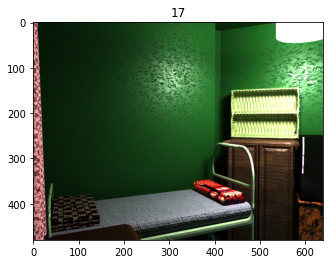

17it [00:05,  2.92it/s]


In [3]:
from tqdm import tqdm
for i, dataBatch in tqdm(enumerate(brdfLoader)):
    print(i)
    if i in [17]:
        im = np.transpose(dataBatch['im'][0].numpy(), (1, 2, 0))
        plt.figure()
        plt.imshow(im)
        plt.title('%d'%i)
        plt.show()
        break
#     else:
#         break
    
#     print(dataBatch)
#     break

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


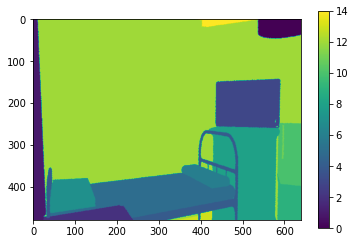

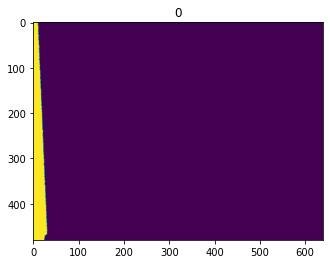

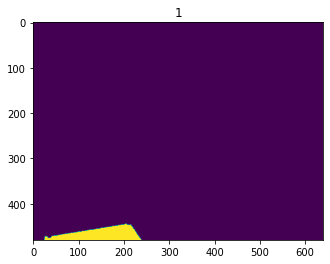

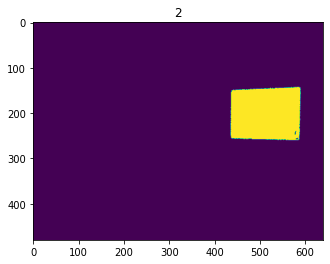

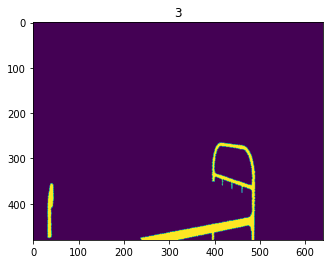

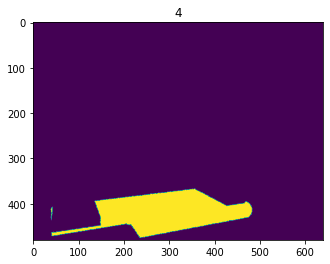

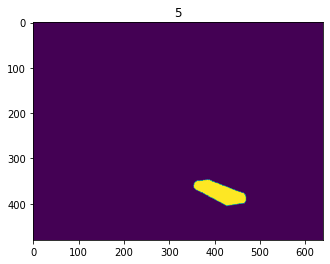

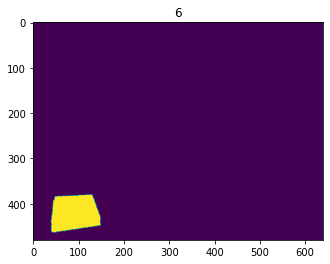

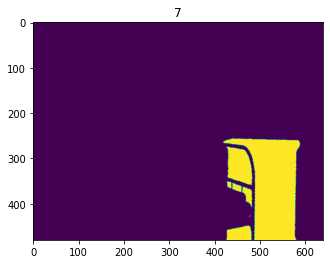

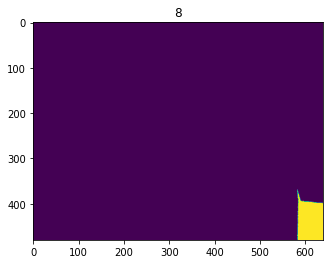

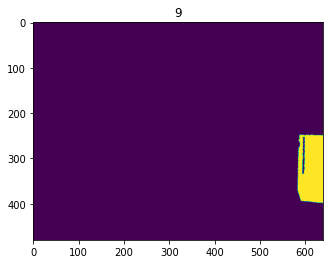

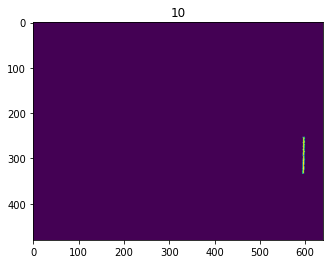

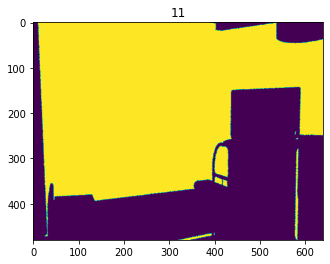

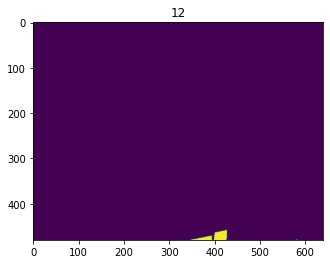

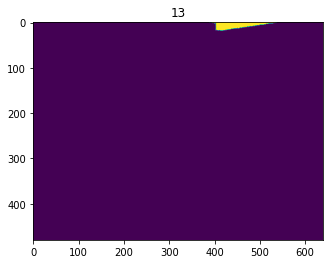

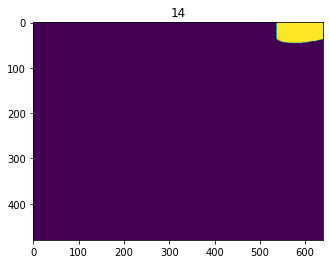

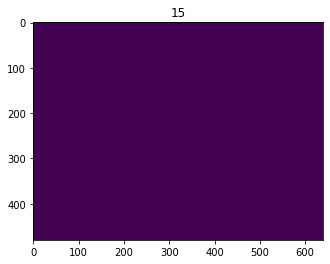

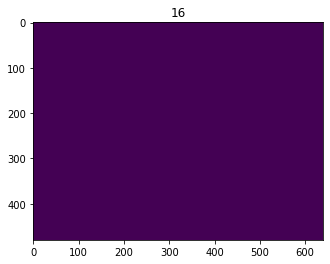

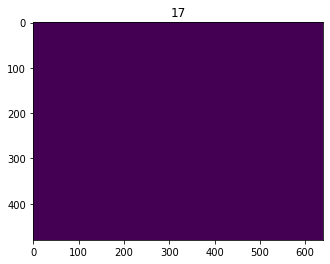

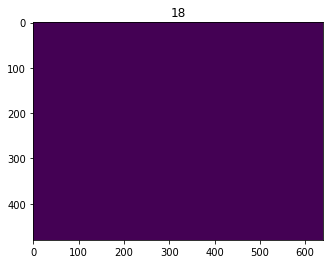

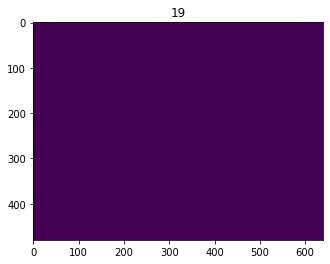

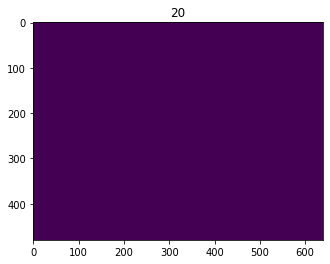

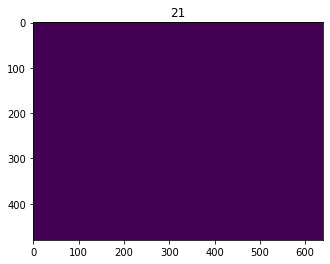

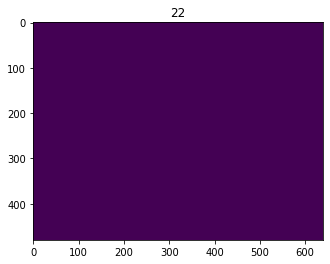

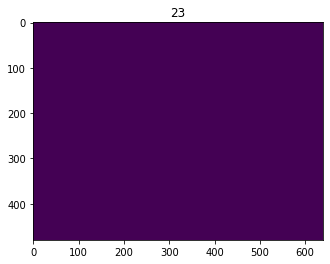

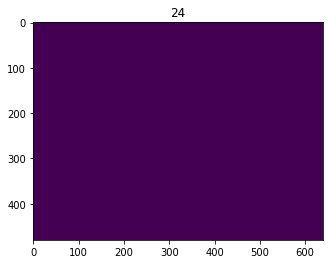

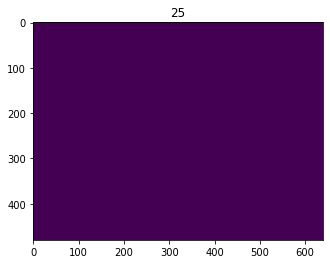

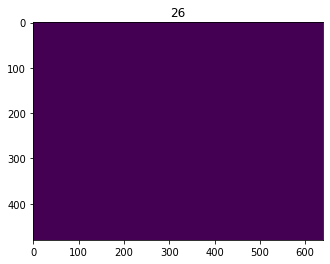

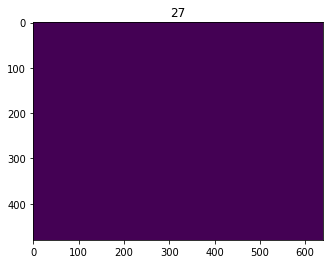

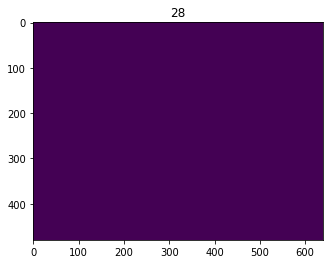

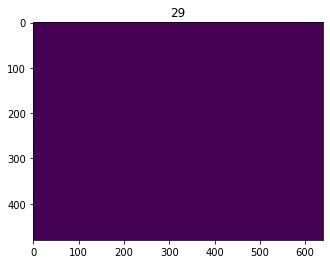

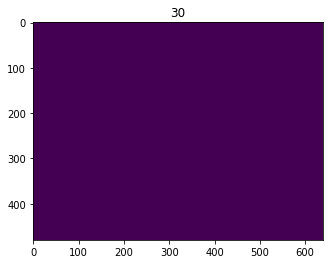

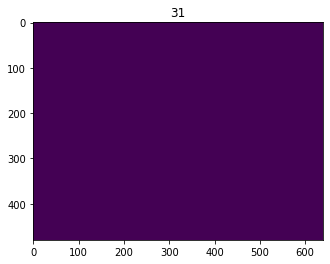

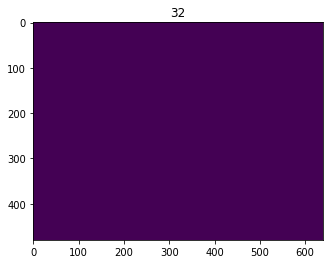

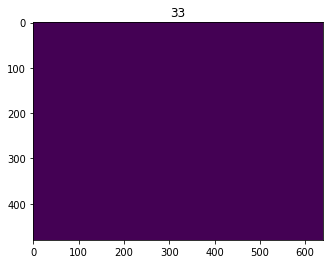

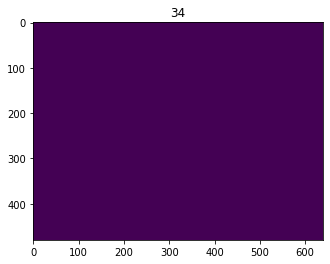

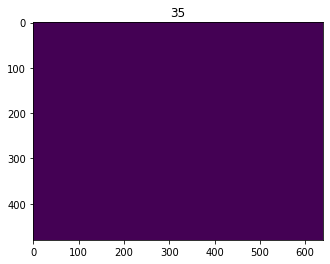

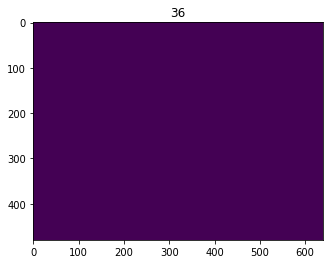

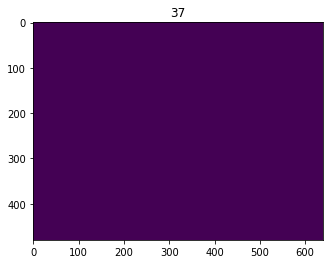

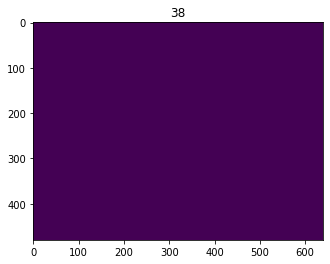

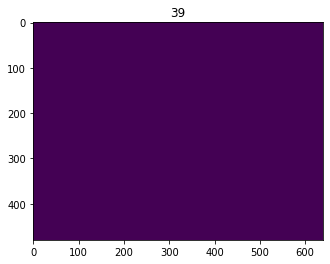

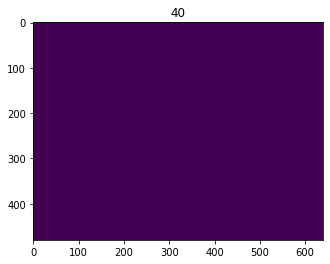

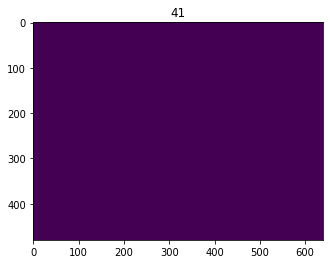

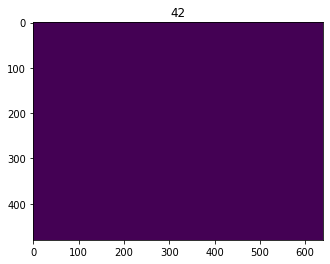

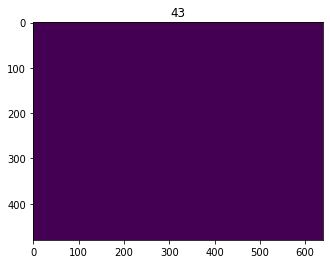

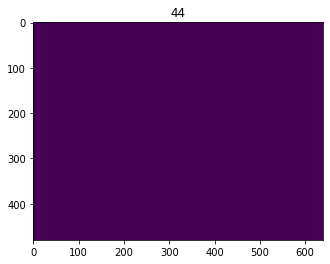

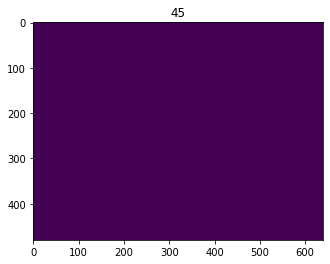

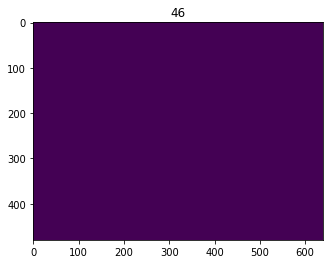

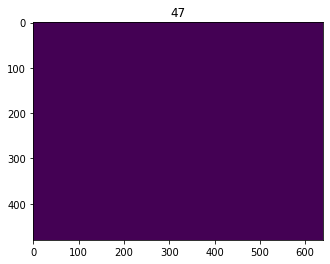

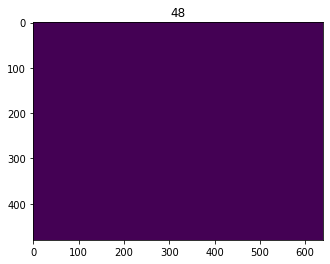

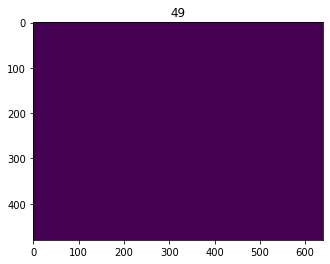

In [4]:
sample = dataBatch

gt_segmentation = sample['mat_aggre_map']
print(np.unique(gt_segmentation))
plt.figure()
plt.imshow(gt_segmentation.numpy().squeeze())
plt.colorbar()
plt.show()

segmentation = sample['instance'][0]
for idx, seg in enumerate(segmentation):
    plt.figure()
    plt.imshow(seg)
    plt.title('%d'%idx)
    plt.show()

In [ ]:
dataBatch.keys()

In [4]:
# mask_path = '../data/mini/main_xml1/scene0024_00/imdepth_2.dat'
# mask_path = '../data/mini/main_xml1/scene0024_00/immatPart_2.dat'

import struct
def loadBinary(imName, dtype=np.float32, if_resize=True):
    with open(imName, 'rb') as fIn:
        hBuffer = fIn.read(4)
        height = struct.unpack('i', hBuffer)[0]
        wBuffer = fIn.read(4)
        width = struct.unpack('i', wBuffer)[0]
        dBuffer = fIn.read(4 * 3 * width * height )
        depth = np.asarray(struct.unpack('i' * 3 * height * width, dBuffer), dtype=np.int32)
        depth = depth.reshape([height, width, 3] )
    return depth
            
import numpy as np
im = np.transpose(dataBatch['im'][0].numpy(), (1, 2, 0))
albedo = np.transpose(dataBatch['albedo'][0].numpy(), (1, 2, 0))
depth = dataBatch['depth'][0].numpy().squeeze()
objMask = dataBatch['mask'][0].numpy().squeeze()

# objMask = loadBinary(dataBatch['matMaskPath'][0], if_resize=False).squeeze()[:, :, 2]

print(np.amax(objMask), np.amin(objMask), np.mean(objMask), objMask.dtype, objMask.shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(30, 15))
plt.subplot(231)
plt.imshow(im)
plt.subplot(232)
plt.imshow(albedo)
plt.subplot(233)
plt.imshow(depth)
plt.subplot(234)
plt.imshow(objMask[:, :, 0])
plt.colorbar()
plt.subplot(235)
plt.imshow(objMask[:, :, 1])
plt.colorbar()
plt.subplot(236)
plt.imshow(objMask[:, :, 2])
plt.colorbar()
plt.show()

NameError: name 'dataBatch' is not defined

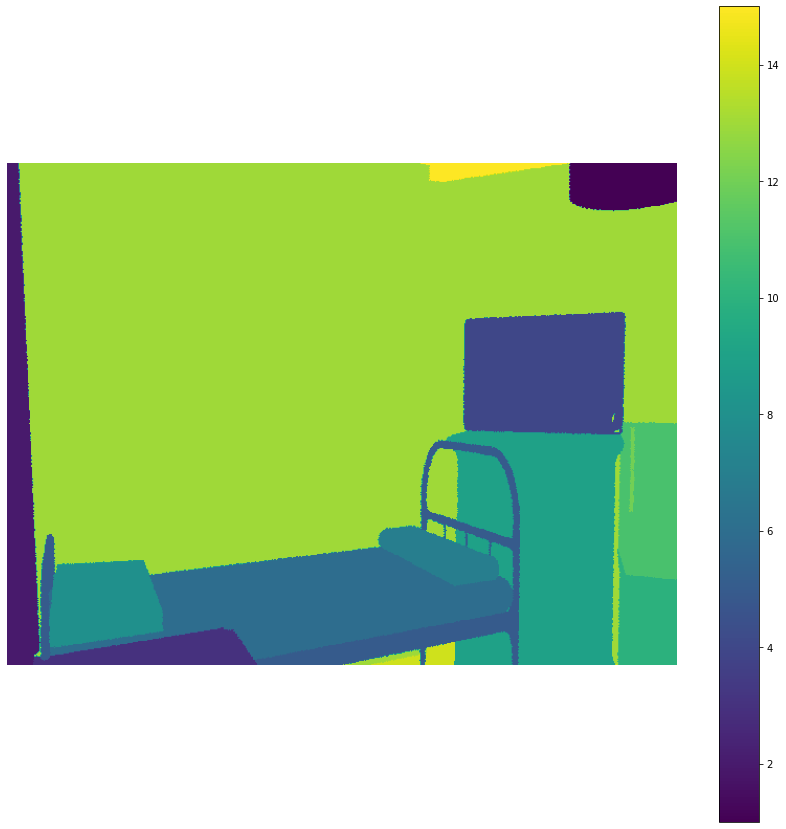

In [7]:
mat_aggre_map = dataBatch['mat_aggre_map'].numpy().squeeze()
plt.figure(figsize=(15, 15))
# plt.imshow(depth)
plt.imshow(mat_aggre_map)
plt.colorbar()
plt.axis('off')
plt.show()

In [18]:
import numpy as np
import colorsys

def _get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

num_colors = np.amax(mat_aggre_map)
colors = _get_colors(num_colors)

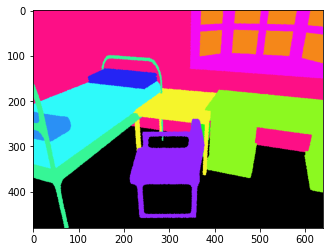

In [25]:
mat_aggre_map_vis = np.zeros((mat_aggre_map.shape[0], mat_aggre_map.shape[1], 3))
for color_idx, color in enumerate(colors):
    mask = mat_aggre_map == color_idx
    mat_aggre_map_vis[mask] = color
    
plt.figure()
plt.imshow(mat_aggre_map_vis)
plt.show()

1 [1] 1 10243


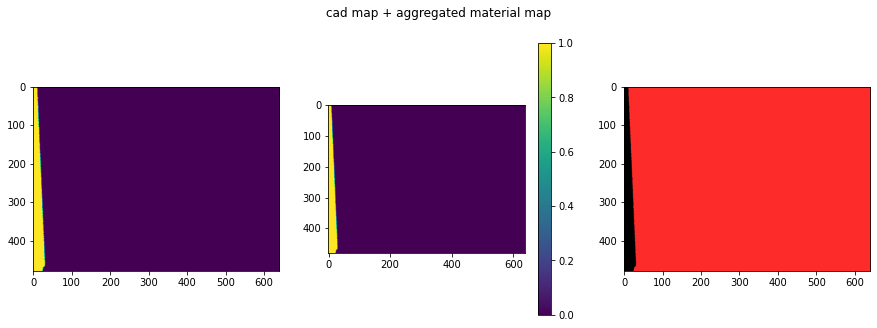

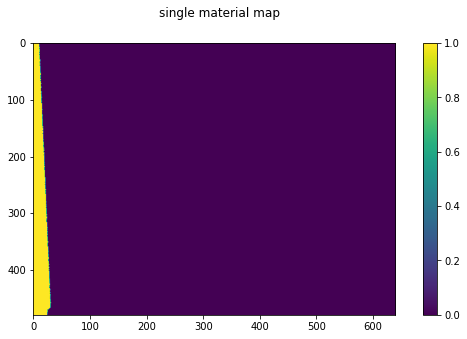

450 [1] 2 4478


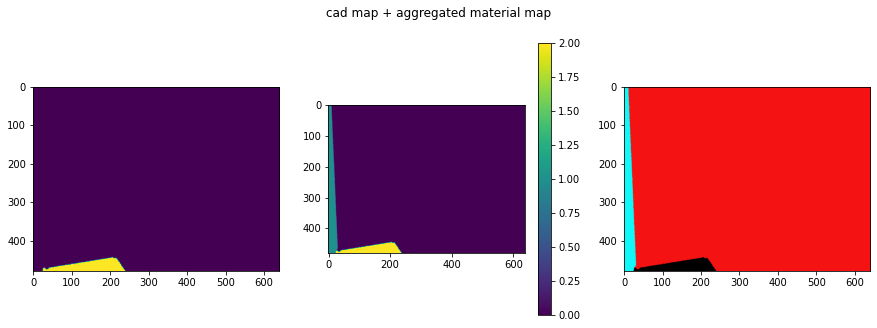

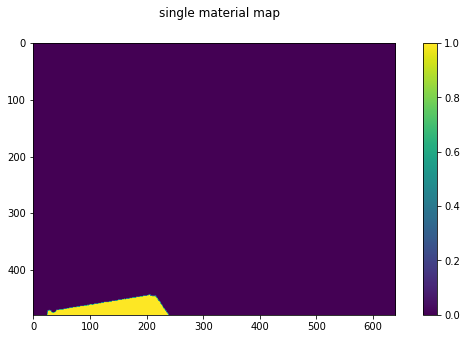

931 [1] 3 17067


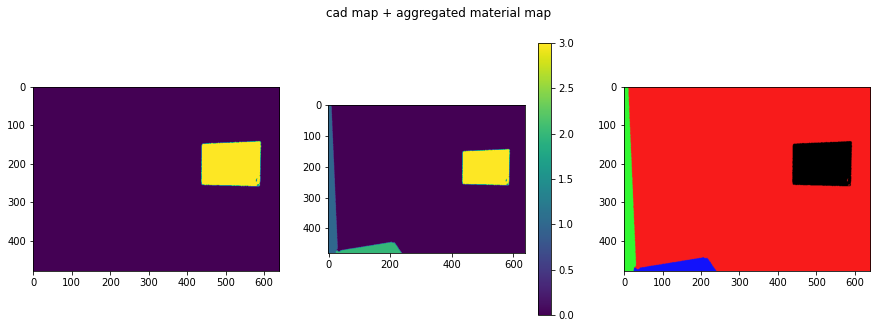

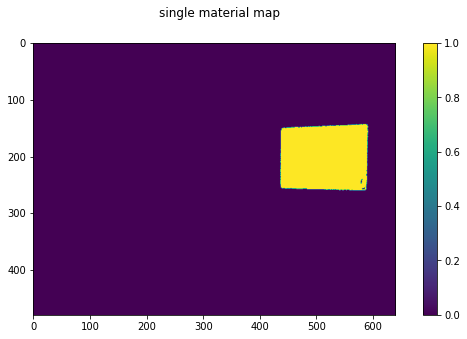

1419 [1 2 3 4] 7 43020


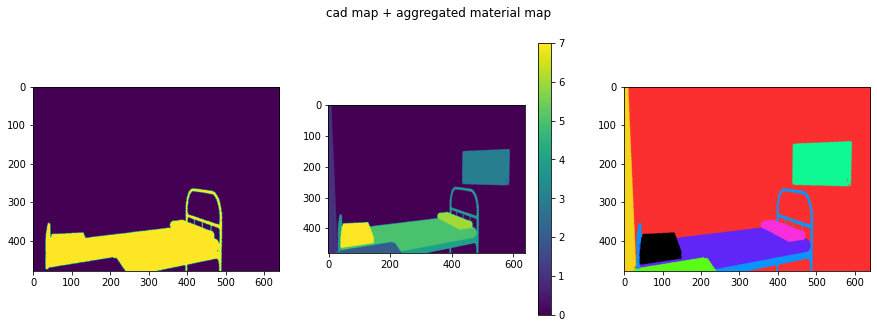

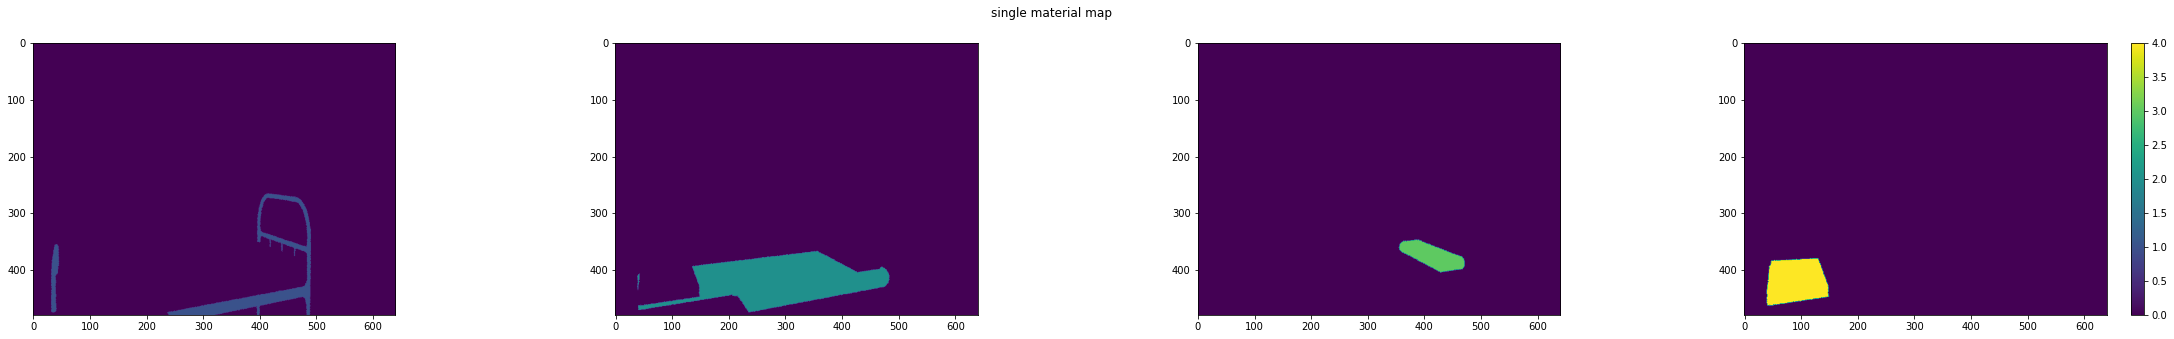

2937 [1] 8 27383


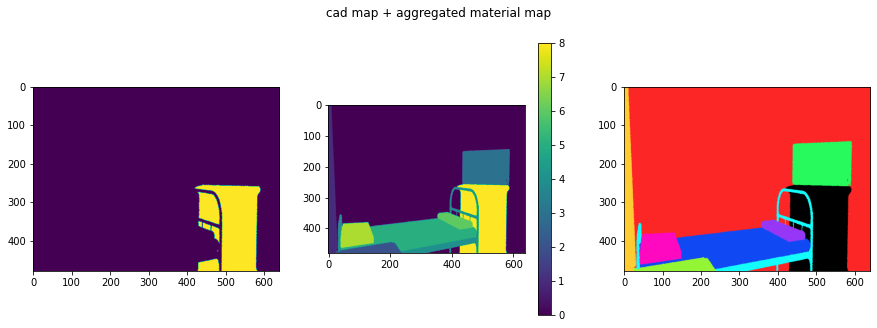

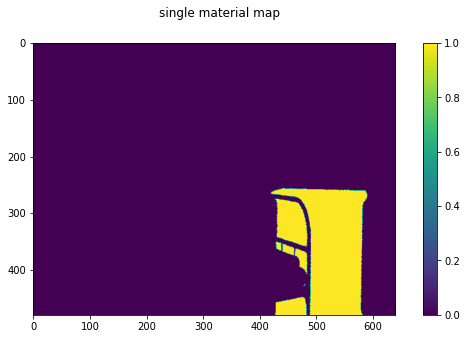

3007 [1] 9 4754


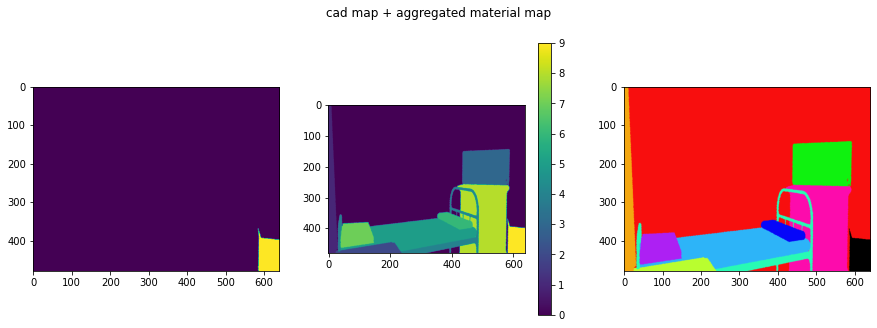

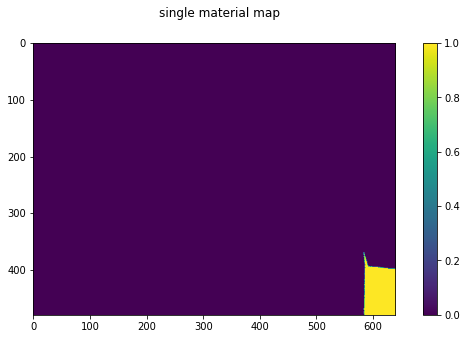

3029 [1 2] 11 7974


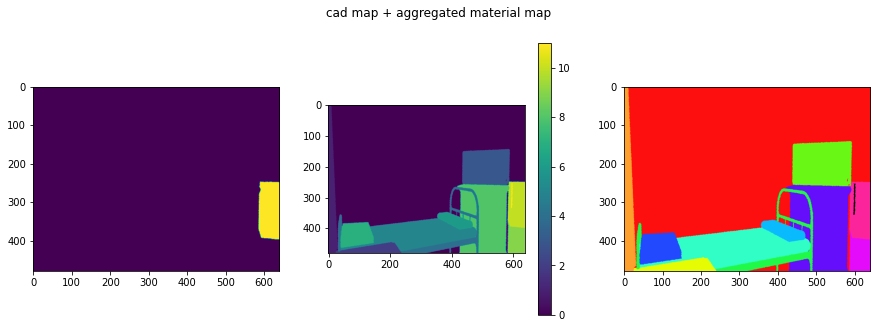

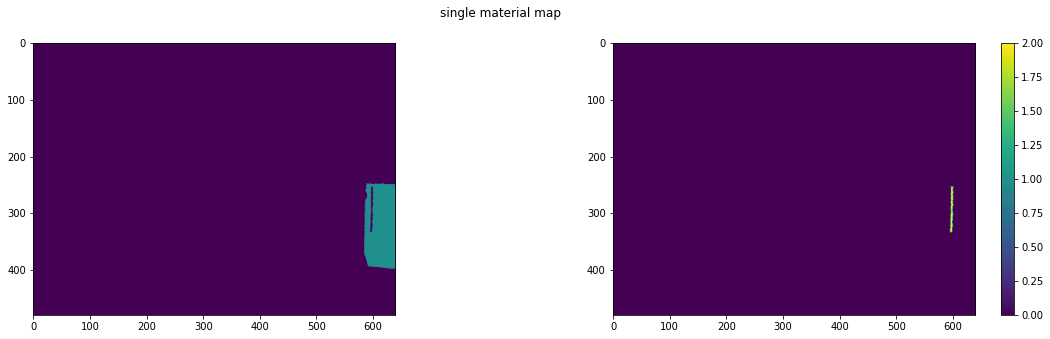

3662 [1 2 3] 14 187821


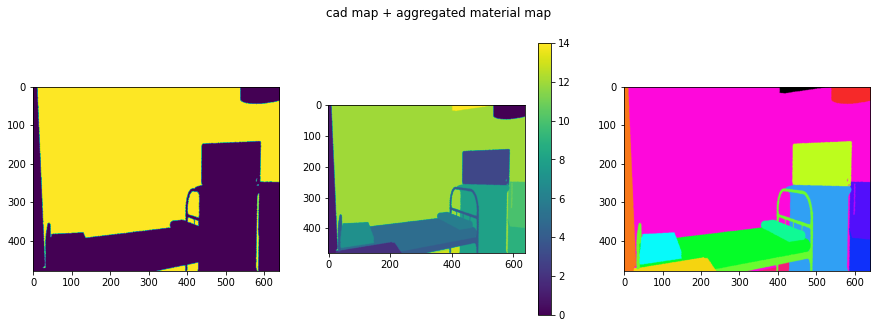

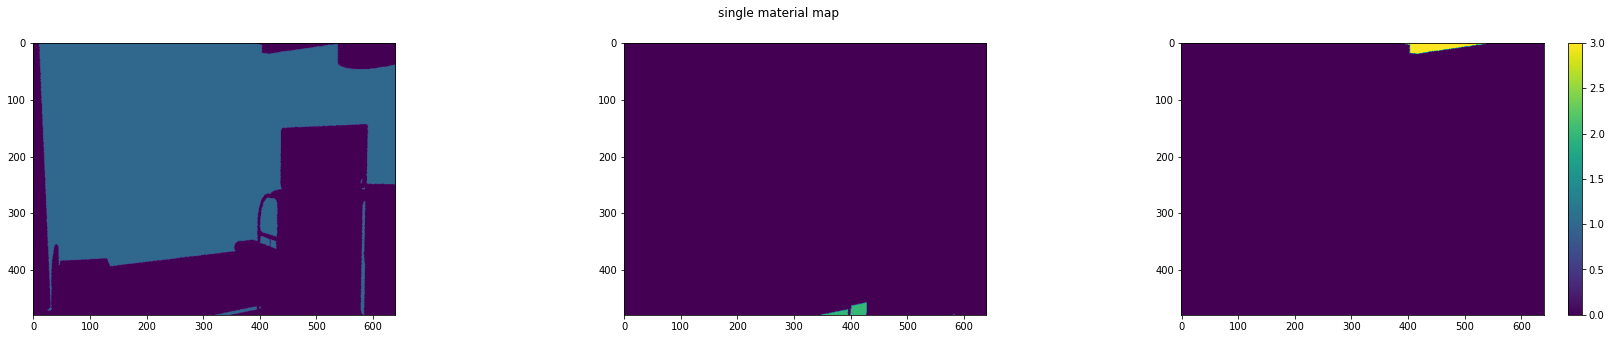

In [7]:
from utils.utils_vis import vis_index_map

cad_map = objMask[:, :, 0] # first channel: cad_id map (group same cad model together)
mat_idx_map = objMask[:, :, 1] # second channel: material INDEX map inside each obj
obj_idx_map = objMask[:, :, 2] # 3rd channel: object INDEX map

mat_aggre_map = np.zeros_like(cad_map)
cad_ids = np.unique(cad_map)
num_mats = 1
for cad_id in cad_ids: # go over each cad model
#     if cad_id != 2976:
#         continue
    cad_mask = cad_map == cad_id
    mat_index_map_cad = mat_idx_map[cad_mask] # get the internal material index map for that object
    mat_idxes = np.unique(mat_index_map_cad)
    
    obj_idx_map_cad = obj_idx_map[cad_mask]
#     print('--', np.unique(obj_idx_map_cad))
    if_light = list(np.unique(obj_idx_map_cad))==[0]
#     print('if_light', if_light, np.unique(obj_idx_map_cad))
    if if_light:
        mat_aggre_map[cad_mask] = 0
#         fig1 = plt.figure(figsize=(15, 5))
#         plt.subplot(121)
#         plt.imshow(cad_mask)
#         plt.subplot(122)
#         plt.imshow(mat_aggre_map)
#         plt.colorbar()
#         fig1.suptitle('cad map + aggregated material map; if_light=True')
#         plt.show()
        continue
    
    # copy the internal material index map + offset (num_mats) to the new global material index map
    # this is where yu-ying can change to look for the material ID based on the cad_id and internal material INDEX map (mat_map_cad)
#     mat_aggre_map[cad_mask] = mat_index_map_cad + num_mats

    cad_single_map = np.zeros_like(cad_map)
    cad_single_map[cad_mask] = mat_idx_map[cad_mask]
    for i, mat_idx in enumerate(mat_idxes):
#         mat_single_map = np.zeros_like(cad_map)
        mat_aggre_map[cad_single_map==mat_idx] = num_mats
        num_mats += 1
    
#     num_mats = num_mats + max(mat_idxes)
    
    print(cad_id, mat_idxes, num_mats-1, np.sum(cad_mask))
    
    fig1 = plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(cad_mask)
    plt.subplot(132)
    plt.imshow(mat_aggre_map)
    plt.colorbar()
    plt.subplot(133)
    plt.imshow(vis_index_map(mat_aggre_map))
    fig1.suptitle('cad map + aggregated material map')
    plt.show()
    
    fig2 = plt.figure(figsize=(10*len(mat_idxes), 5))
    cad_single_map = np.zeros_like(cad_map)
    cad_single_map[cad_mask] = mat_idx_map[cad_mask]
    for i, mat_idx in enumerate(mat_idxes):
        mat_single_map = np.zeros_like(cad_map)
        mat_single_map[cad_single_map==mat_idx] = mat_idx
        plt.subplot(1, len(mat_idxes), i+1)
        plt.imshow(mat_single_map, vmin=0, vmax=np.max(mat_idxes))
    plt.colorbar()
    fig2.suptitle('single material map')
    plt.show()
    
#     break

# Check new entries

In [8]:
dataBatch.keys()

dict_keys(['albedo', 'normal', 'rough', 'depth', 'mask', 'maskPath', 'segArea', 'segEnv', 'segObj', 'im', 'object_type_seg', 'image_path', 'mat_aggre_map', 'num_mat_masks', 'mat_notlight_mask', 'instance', 'semantic', 'image_transformed', 'im_not_hdr'])

In [14]:
segmentation.shape

torch.Size([1, 50, 480, 640])

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13 255]


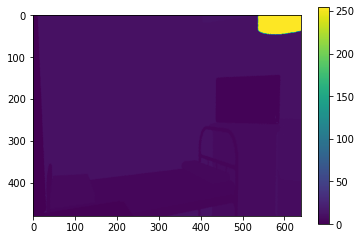

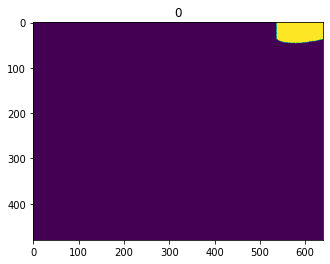

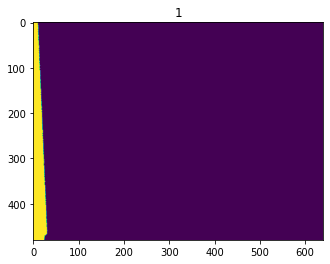

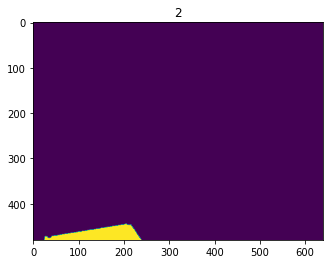

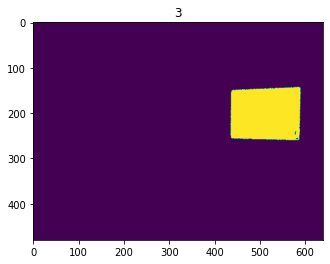

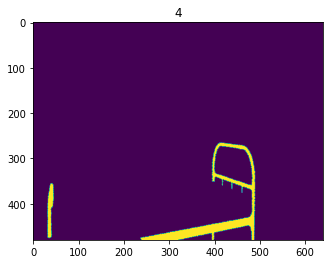

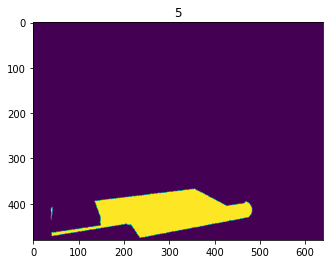

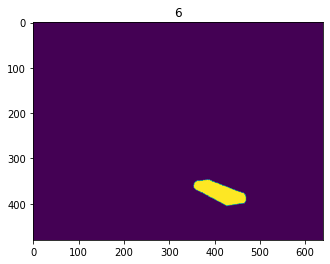

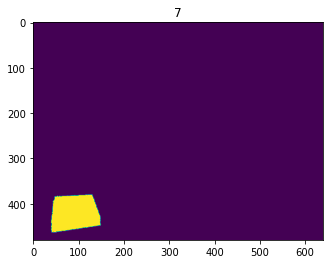

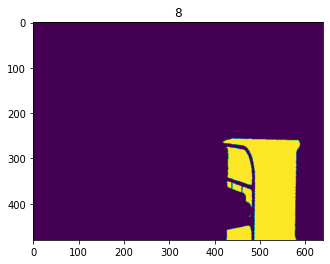

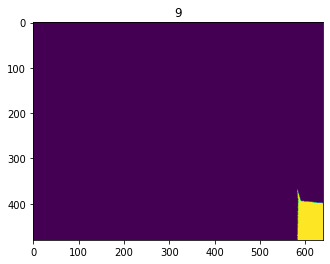

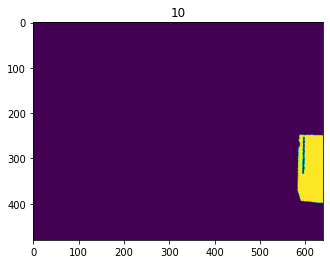

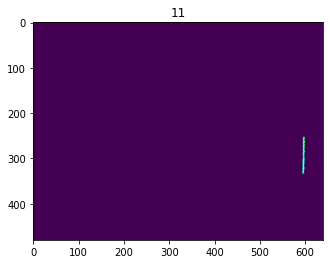

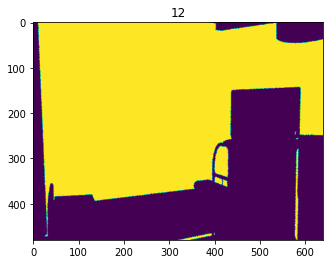

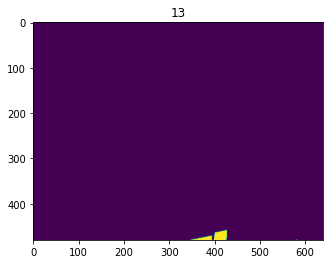

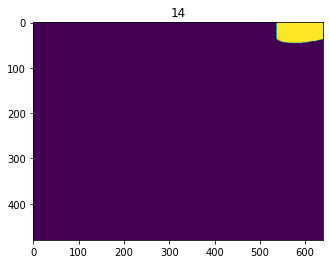

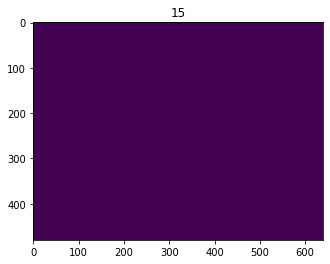

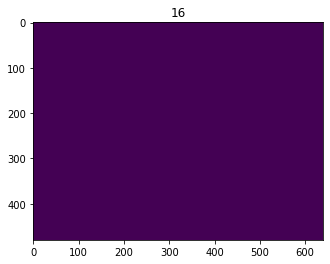

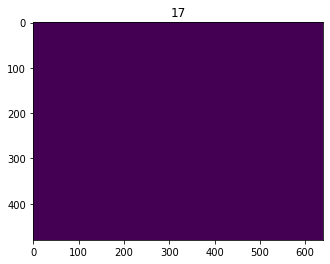

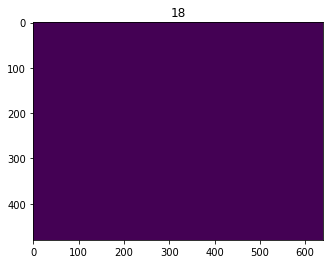

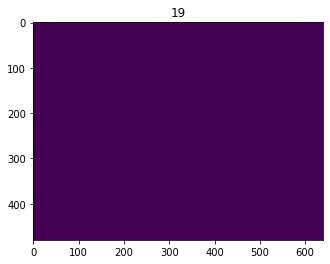

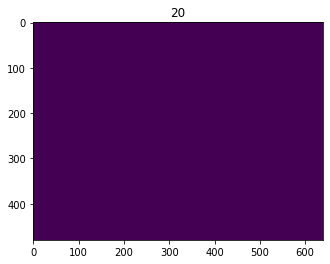

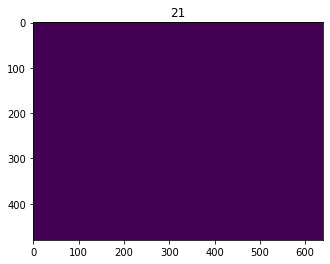

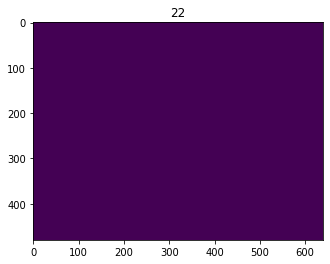

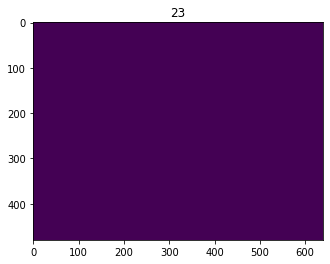

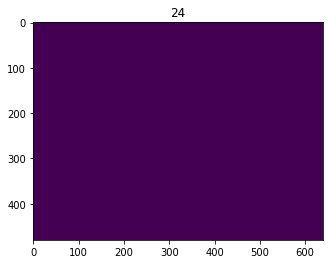

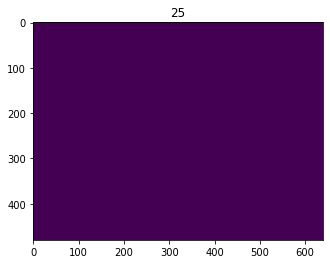

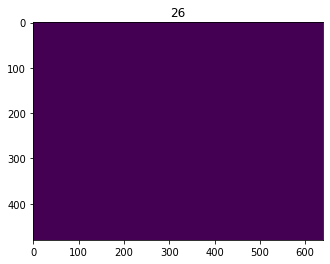

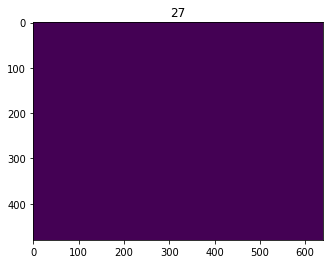

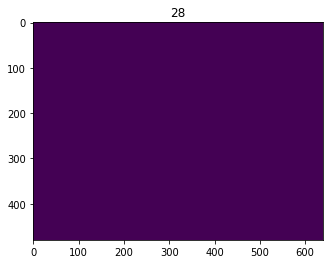

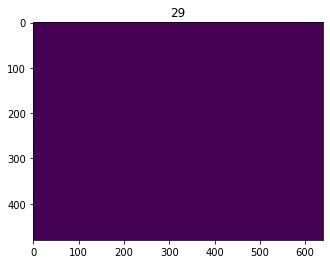

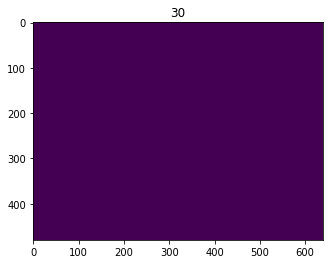

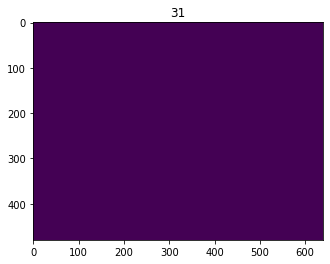

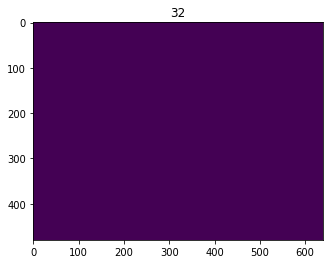

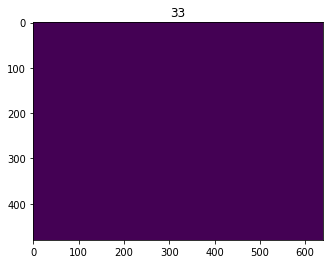

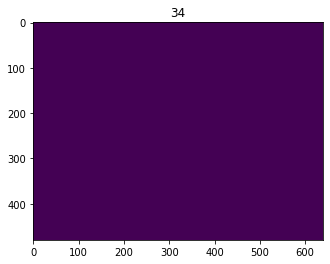

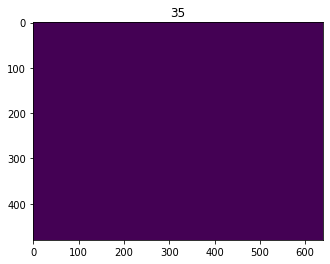

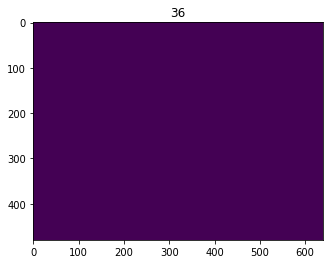

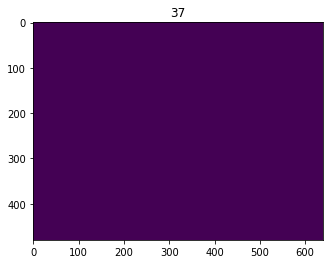

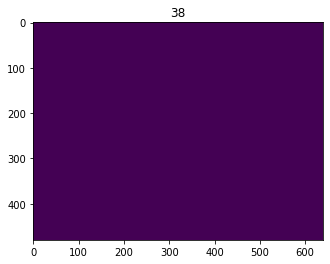

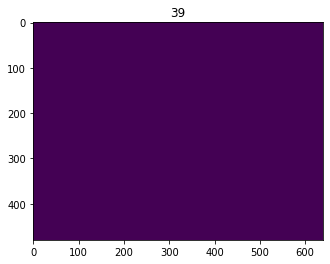

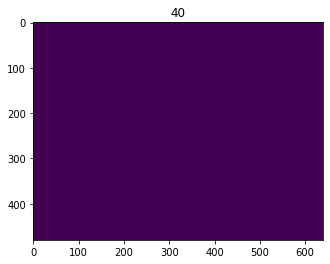

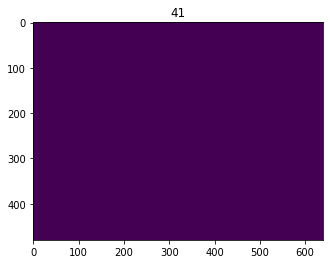

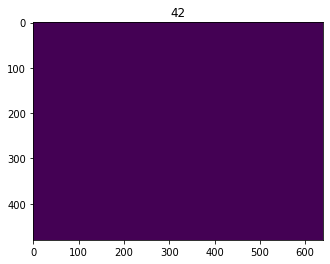

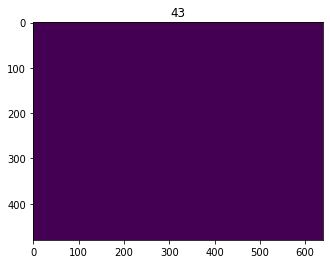

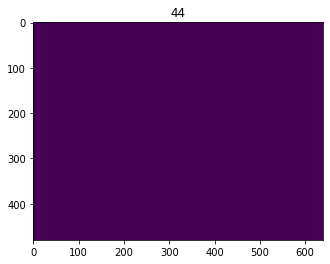

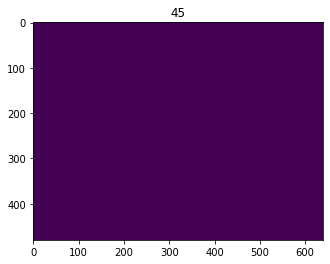

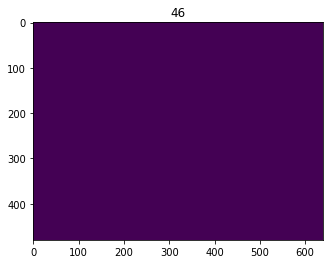

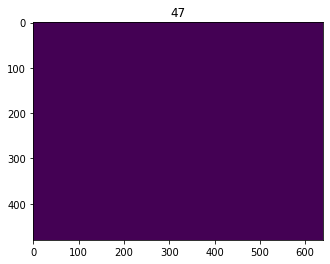

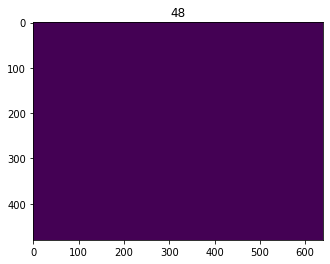

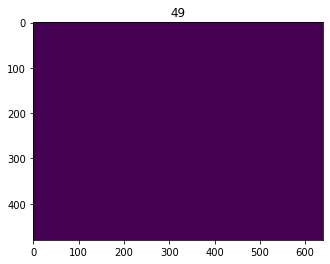

In [15]:
sample = dataBatch

gt_segmentation = sample['mat_aggre_map_reindex']
print(np.unique(gt_segmentation))
plt.figure()
plt.imshow(gt_segmentation.numpy().squeeze())
plt.colorbar()
plt.show()

segmentation = sample['instance'][0]
for idx, seg in enumerate(segmentation):
    plt.figure()
    plt.imshow(seg)
    plt.title('%d'%idx)
    plt.show()